In [83]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel, \
    LinearKernel, ProductKernel, MaternKernel, SpectralMixtureKernel

import tqdm

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0,"..")

# from modules.HetMOGP import HetMOGP
from modules.additive_hmogp import HetMOGP

In [50]:
df = pd.read_csv('msl_evasion-001.csv')
log_standardise = lambda x: (np.log(x) - np.mean(np.log(x))) / np.std(np.log(x))
normalise = lambda x: (np.log(x) - np.min(np.log(x))) / (np.max(np.log(x)) - np.min(np.log(x)))

df["logstd_viper_briefed_launch_range"] = df.viper_briefed_launch_range.pipe(log_standardise)
df["lognorm_viper_briefed_launch_range"] = df.viper_briefed_launch_range.pipe(normalise)
df["logstd_cobra_briefed_evasion_range"] = df.cobra_briefed_evasion_range.pipe(log_standardise)
df["lognorm_cobra_briefed_evasion_range"] = df.cobra_briefed_evasion_range.pipe(normalise)

<AxesSubplot:xlabel='logstd_viper_briefed_launch_range', ylabel='Density'>

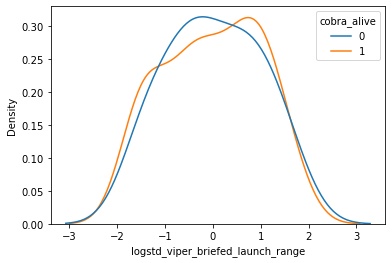

In [51]:
sns.kdeplot(df.logstd_viper_briefed_launch_range, hue=df.cobra_alive, common_norm=False)

<AxesSubplot:xlabel='lognorm_viper_briefed_launch_range', ylabel='Density'>

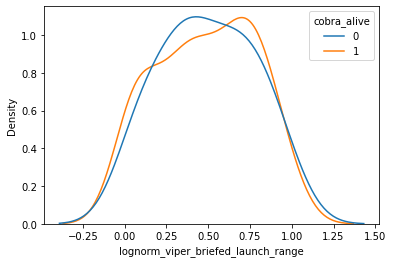

In [53]:
sns.kdeplot(df.lognorm_viper_briefed_launch_range, hue=df.cobra_alive, common_norm=False)

<AxesSubplot:xlabel='logstd_cobra_briefed_evasion_range', ylabel='Density'>

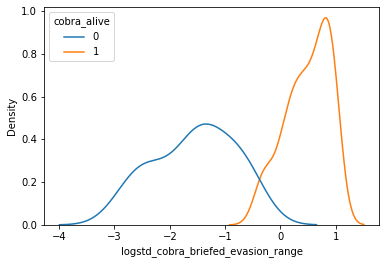

In [54]:
sns.kdeplot(df.logstd_cobra_briefed_evasion_range, hue=df.cobra_alive, common_norm=False)

<AxesSubplot:xlabel='lognorm_cobra_briefed_evasion_range', ylabel='Density'>

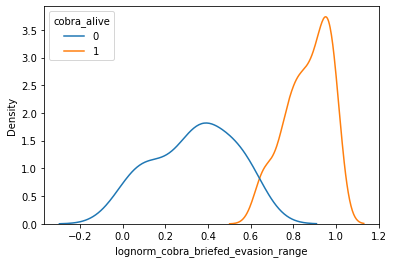

In [55]:
sns.kdeplot(df.lognorm_cobra_briefed_evasion_range, hue=df.cobra_alive, common_norm=False)

<AxesSubplot:xlabel='logstd_viper_briefed_launch_range', ylabel='cobra_alive'>

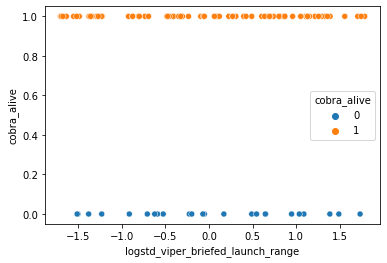

In [57]:
sns.scatterplot(df.logstd_viper_briefed_launch_range, df.cobra_alive, hue=df.cobra_alive)

<AxesSubplot:xlabel='lognorm_cobra_briefed_evasion_range', ylabel='cobra_alive'>

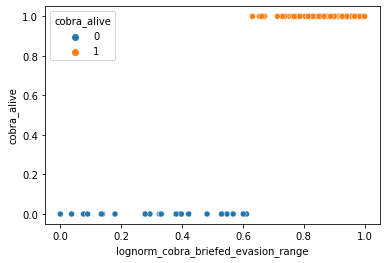

In [60]:
sns.scatterplot(df.lognorm_cobra_briefed_evasion_range, df.cobra_alive, hue=df.cobra_alive)

<AxesSubplot:xlabel='lognorm_viper_briefed_launch_range', ylabel='lognorm_cobra_briefed_evasion_range'>

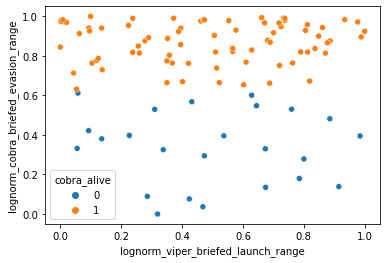

In [62]:
sns.scatterplot(df.lognorm_viper_briefed_launch_range, df.lognorm_cobra_briefed_evasion_range, hue=df.cobra_alive)

In [88]:
input = [
    "lognorm_viper_briefed_launch_range",
    "lognorm_cobra_briefed_evasion_range"
]

outcome = [
    "cobra_alive"
]

X = torch.tensor(df[input].values, dtype=torch.float)
y = torch.tensor(df[outcome].values, dtype=torch.float)

In [97]:
train_idx, test_idx = torch.utils.data.random_split(X, [.7, .3])
train_idx, test_idx = train_idx.indices, test_idx.indices

train_x = X[train_idx,:]
test_x = X[test_idx,:]
train_y = y[train_idx,:]
test_y = y[test_idx,:]

# train_y = torch.stack([y_1, y_2], dim=-1)
# train_y = y_1
if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

In [90]:
gamma_mean = 1
gamma_std = 1
alpha = gamma_mean**2 / np.sqrt(gamma_std)
beta = gamma_mean / np.sqrt(gamma_std)
lengthscale_prior = gpytorch.priors.GammaPrior(alpha, beta)

batch_shape=torch.Size([1])
kernels = [
    ScaleKernel(RBFKernel(batch_shape=batch_shape), batch_shape=batch_shape),
    ScaleKernel(RBFKernel(batch_shape=batch_shape), batch_shape=batch_shape)
]
likelihoods = ["Bernoulli"]
active_dims = [[0], [1]]

HetMOGP.ELBO_NORMALISER = train_y.size(0)
model = HetMOGP(train_x, num_lpf=1, likelihoods=likelihoods, kernels=kernels, active_dims=active_dims, num_inducing=100, jitter_val = 1e-9)

if torch.cuda.is_available():
    model = model.cuda()

In [91]:
pyro.clear_param_store()

# num_iter = 2000
num_iter = 1200 # for actual training
# num_iter = 500 # for testing if the code works
num_particles = 10

# If getting Matrix not PSD error try:
# - decreasing gamma = 1e-3 / decreasing final_lr = 1e-3 or lower (for fast training, try final_lr = 1e-2)
# - decreasing num_iter

initial_lr = 1e-1
final_lr = 1e-3
gamma = final_lr / initial_lr  # final learning rate will be gamma * initial_l|r
lrd = gamma ** (1 / num_iter) # learning rate decay

optimizer = pyro.optim.ClippedAdam({
    'lr': initial_lr, 
    'lrd': lrd,
    'betas': (0.95, 0.999)})

elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)

model.train()
iterator = tqdm.notebook.tqdm(range(num_iter), desc="Epoch")
loss_array = np.zeros(num_iter)
for i in iterator:
    model.zero_grad()
    loss = svi.step(x=train_x, y=train_y)
    loss_array[i] = loss
    iterator.set_postfix(loss=loss)

Epoch:   0%|          | 0/1200 [00:00<?, ?it/s]

<AxesSubplot:>

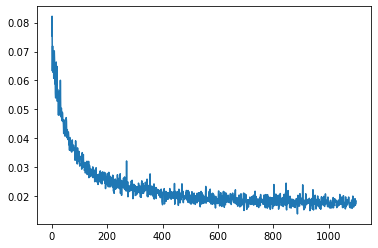

In [92]:
fig, ax = plt.subplots(figsize=(7,4))
loss_start = 100
ax.plot(np.arange(0, len(loss_array) - loss_start), loss_array[loss_start:])
ax.set_xlabel(r"iteration", fontdict={'fontsize':15})
ax.set_ylabel(r"scaled neg ELBO", fontdict={'fontsize':15})
ax.set_title(r"Loss function = neg ELBO scaled", fontsize=20);

In [94]:
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]

    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]

    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]

    return percentile_samples

In [98]:
n_posterior_samples = 1000

model.eval()

with torch.no_grad():
    output = model(test_x)
    output_train = model(train_x)

# Similarly get the 5th and 95th percentiles
samples = output(torch.Size([n_posterior_samples]))
samples_train = output_train(torch.Size([n_posterior_samples]))

lower, mean, upper = percentiles_from_samples(samples.cpu())
lower_train, mean_train, upper_train = percentiles_from_samples(samples_train.cpu())
train_x, train_y, test_x, test_y = train_x.cpu(), train_y.cpu(), test_x.cpu(), test_y.cpu()

# Draw some simulated y values
y_sim = torch.stack(
    [dist.Bernoulli(torch.sigmoid(mean[:,0].detach()))()],
    dim=-1
)

y_sim_train = torch.stack(
    [dist.Bernoulli(torch.sigmoid(mean_train[:,0].detach()))()],
    dim=-1
)

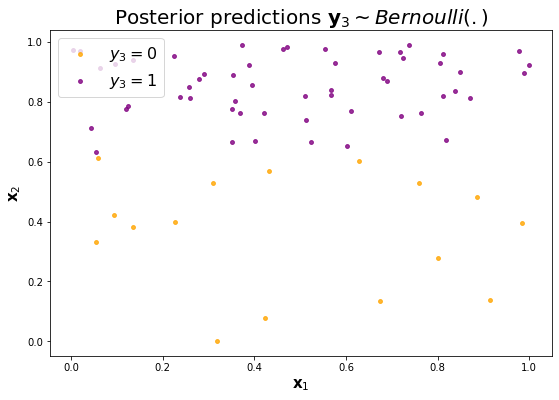

In [101]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,6))

idx_0 = (y_sim_train[:,0]==0).nonzero().flatten()
idx_1 = (y_sim_train[:,0]==1).nonzero().flatten()

ax.scatter(train_x[idx_0,0], train_x[idx_0,1], s=15, alpha=.8, marker='o', c="orange", label=r'$y_3=0$')
ax.scatter(train_x[idx_1,0], train_x[idx_1,1].cpu().detach().numpy(), s=15, alpha=.8, marker='o', c="purple", label=r'$y_3=1$')
ax.legend(loc=2, prop={'size': 16})

ax.set_xlabel(r"$\mathbf{x}_1$", fontdict={'fontsize':15})
ax.set_ylabel(r"$\mathbf{x}_2$", fontdict={'fontsize':15})
ax.set_title(r"Posterior predictions $\mathbf{y}_3 \sim Bernoulli(.)$", fontsize=20);

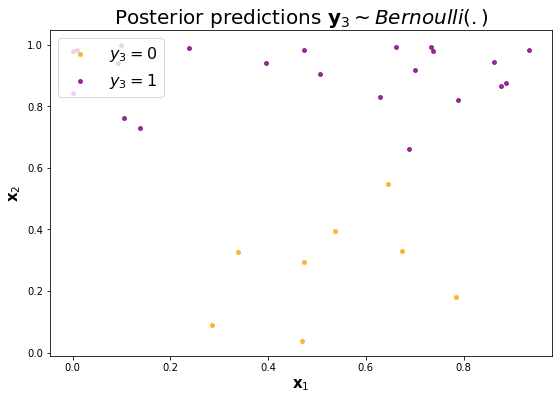

In [102]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,6))

idx_0 = (y_sim[:,0]==0).nonzero().flatten()
idx_1 = (y_sim[:,0]==1).nonzero().flatten()

ax.scatter(test_x[idx_0,0], test_x[idx_0,1], s=15, alpha=.8, marker='o', c="orange", label=r'$y_3=0$')
ax.scatter(test_x[idx_1,0], test_x[idx_1,1].cpu().detach().numpy(), s=15, alpha=.8, marker='o', c="purple", label=r'$y_3=1$')
ax.legend(loc=2, prop={'size': 16})

ax.set_xlabel(r"$\mathbf{x}_1$", fontdict={'fontsize':15})
ax.set_ylabel(r"$\mathbf{x}_2$", fontdict={'fontsize':15})
ax.set_title(r"Posterior predictions $\mathbf{y}_3 \sim Bernoulli(.)$", fontsize=20);

In [103]:
model.eval()

with torch.no_grad():
    latent_dist_draw = model.variational_strategy.latent_dist.sample(torch.Size([1000]))
    latent_dist_draw = latent_dist_draw.cpu()
    
    lmc_coefficients = model.variational_strategy.lmc_coefficients
    lmc_coefficients = lmc_coefficients.cpu()
    test = model.variational_strategy.latent_dist

lower_latent, mean_latent, upper_latent = percentiles_from_samples(latent_dist_draw)

In [104]:
def eigen(lmc_coefficients, norm=True, round=5):
    
    V_mat = lmc_coefficients.T @ lmc_coefficients
    if norm:
        V_mat = torch.divide(V_mat, torch.norm(V_mat, dim=-1).unsqueeze(-1))
    V_eigval, V_eigvec = np.linalg.eig(V_mat)
    idx_sort = np.argsort(V_eigval)[::-1]
    V_eigval, V_eigvec = V_eigval[idx_sort], V_eigvec[:,idx_sort]
    V_eigval, V_eigvec = np.round(V_eigval, round), np.round(V_eigvec, round)

    return V_eigval, V_eigvec

In [105]:
V_mat = lmc_coefficients.T @ lmc_coefficients
V_eigval, V_eigvec = np.linalg.eig(V_mat)

In [115]:
train_x.shape

torch.Size([70, 2])

Text(0.5, 1.0, 'Independent Latent Function $u_2^{(1)}, k_{SE} \\times k_{Lin}$')

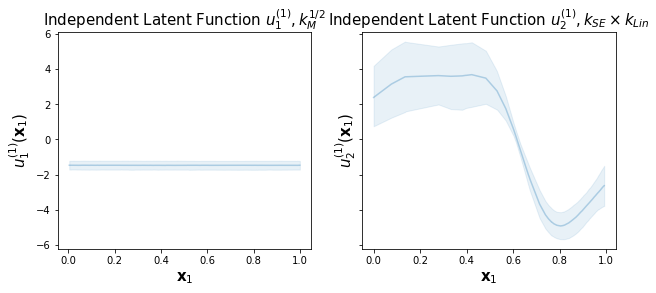

In [116]:
# visualize the result
fig, func = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)

for i in range(2):
    indices = np.argsort(train_x[:,i])
    line, = func[i].plot(train_x[indices,i], mean_latent[i,indices], alpha=0.3)
    func[i].fill_between(
        train_x[indices,i], lower_latent[i,indices],
        upper_latent[i,indices], alpha=0.1, color=line.get_color()
    )
    func[i].set_xlabel(r"$\mathbf{x}_1$", fontdict={'fontsize':15})
func[0].set_ylabel(r"$u_1^{(1)}(\mathbf{x}_1)$", fontdict={'fontsize':15})
func[0].set_title(r"Independent Latent Function $u_1^{(1)}, k_{M}^{1/2}$", fontdict={'fontsize':15})
func[1].set_ylabel(r"$u_2^{(1)}(\mathbf{x}_1)$", fontdict={'fontsize':15})
func[1].set_title(r"Independent Latent Function $u_2^{(1)}, k_{SE} \times k_{Lin}$", fontdict={'fontsize':15})

In [118]:
def compute_f_pd(input, d_lpf, lpf, lmc, active_dims, get_indices=True):
    active_dims = np.array(active_dims)
    lpf_idx, _ = np.where(active_dims==[input])
    indices = np.argsort(train_x[:,input])
    f_pd = (lpf.T[:,lpf_idx] @ lmc[lpf_idx,:])[indices,d_lpf]
    if get_indices:
        return indices, f_pd
    else:
        return f_pd

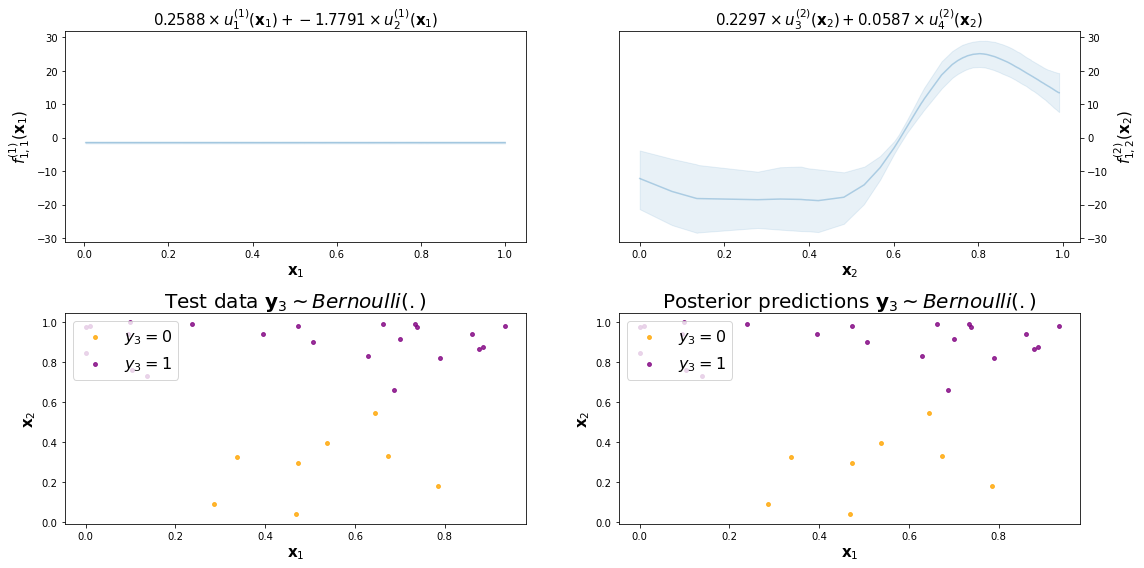

In [123]:
# visualize the result
fig, func = plt.subplots(2, 2, figsize=(16, 8))

for i in range(2):
    for j in range(2):
        if i == 0:
            indices, f11_mean = compute_f_pd(j, 0, mean_latent, lmc_coefficients, active_dims)
            _, f11_lower = compute_f_pd(j, 0, lower_latent, lmc_coefficients, active_dims)
            _, f11_upper = compute_f_pd(j, 0, upper_latent, lmc_coefficients, active_dims)
            line, = func[i,j].plot(train_x[indices,j], f11_mean, alpha=0.3)
            func[i,j].fill_between(
                train_x[indices,j], f11_lower,
                f11_upper, alpha=0.1, color=line.get_color()
            )
            func[i,j].sharey(func[0,0])



func[0,0].set_ylabel(r"$f_{1,1}^{(1)}(\mathbf{x}_1)$", fontdict={'fontsize':15})
func[0,0].set_xlabel(r"$\mathbf{x}_1$", fontsize=15)
func[0,1].set_ylabel(r"$f_{1,2}^{(2)}(\mathbf{x}_2)$", fontdict={'fontsize':15})
func[0,1].set_xlabel(r"$\mathbf{x}_2$", fontsize=15)
func[0,0].set_title(r"$0.2588 \times u_1^{(1)}(\mathbf{x}_1) + -1.7791 \times u_2^{(1)}(\mathbf{x}_1)$", fontdict={'fontsize':15})
func[0,1].set_title(r"$0.2297 \times u_3^{(2)}(\mathbf{x}_2) + 0.0587 \times u_4^{(2)}(\mathbf{x}_2)$", fontdict={'fontsize':15})
func[1,0].set_xlabel(r"$\mathbf{x}_1$", fontsize=15)
func[1,0].set_ylabel(r"$\mathbf{y}_1 \sim Poisson(.)$", fontsize=15)
func[1,1].set_xlabel(r"$\mathbf{x}_2$", fontsize=15)
func[1,1].set_ylabel(r"$\mathbf{y}_1 \sim Poisson(.)$", fontsize=15)
# func[1,1].set_title(r"Independent Latent Function $u_4^{(2)}, k_{SE} \times k_{Lin}$", fontdict={'fontsize':15})

idx_0 = (test_y[:,0]==0).nonzero().flatten()
idx_1 = (test_y[:,0]==1).nonzero().flatten()

func[1,0].scatter(test_x[idx_0,0], test_x[idx_0,1], s=15, alpha=.8, marker='o', c="orange", label=r'$y_3=0$')
func[1,0].scatter(test_x[idx_1,0], test_x[idx_1,1].cpu().detach().numpy(), s=15, alpha=.8, marker='o', c="purple", label=r'$y_3=1$')
func[1,0].legend(loc=2, prop={'size': 16})

func[1,0].set_xlabel(r"$\mathbf{x}_1$", fontdict={'fontsize':15})
func[1,0].set_ylabel(r"$\mathbf{x}_2$", fontdict={'fontsize':15})
func[1,0].set_title(r"Test data $\mathbf{y}_3 \sim Bernoulli(.)$", fontsize=20);

idx_0 = (y_sim[:,0]==0).nonzero().flatten()
idx_1 = (y_sim[:,0]==1).nonzero().flatten()

func[1,1].scatter(test_x[idx_0,0], test_x[idx_0,1], s=15, alpha=.8, marker='o', c="orange", label=r'$y_3=0$')
func[1,1].scatter(test_x[idx_1,0], test_x[idx_1,1].cpu().detach().numpy(), s=15, alpha=.8, marker='o', c="purple", label=r'$y_3=1$')
func[1,1].legend(loc=2, prop={'size': 16})
func[0,1].yaxis.tick_right()
func[0,1].yaxis.set_label_position("right")

func[1,1].set_xlabel(r"$\mathbf{x}_1$", fontdict={'fontsize':15})
func[1,1].set_ylabel(r"$\mathbf{x}_2$", fontdict={'fontsize':15})
func[1,1].set_title(r"Posterior predictions $\mathbf{y}_3 \sim Bernoulli(.)$", fontsize=20);

fig.tight_layout(w_pad=5)